# Definição e import das bibliotecas utilizadas

In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from skimage import io, color
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Etapas de Pré - Processamento

## Conversão para escala de Cinza

- Essa etapa é importante para garantir que a imagem possa passar adequadamente pela etapa de binarização. Para que a binarização ocorra adequadamente, é preciso que a imagem tenha apenas um canal de cor. Como as assinaturas fornecidas possuem 3 canais (imagem RGB), reduz-se os canais para um único canal em escala de cinza e, posteriormente, aplica-se a binarização, definindo a intensidade dos pixels como 0 ou 255 a partir de algum limiar de decisão.

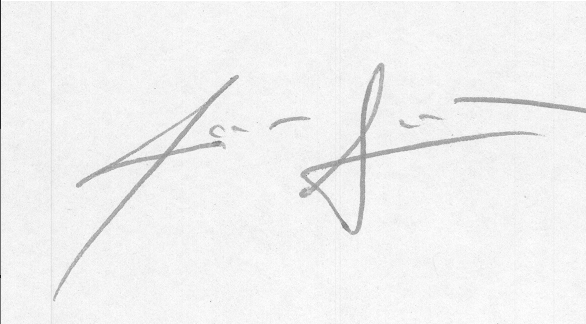

## Binarização:
- A binarização foi realizada na função binarization, a qual recebe uma imagem e, a partir do algoritmo de Otsu, define um treshold e devolve uma imagem binarizada, com o canal de cores único contendo pixels de valor 0 (preto) ou 255 (branco). O algoritmo de Otsu é uma técnica de segmentação de imagens que busca automaticamente determinar o melhor valor de limiar para binarizar uma imagem. Ele funciona encontrando o limiar que minimiza a variabilidade intra-classe (variabilidade dentro das duas classes de pixels resultantes da binarização: pixels brancos e pixels pretos). Em outras palavras, ele tenta encontrar o limiar que melhor separa os objetos de interesse do fundo na imagem, maximizando a diferença entre os objetos e o fundo.

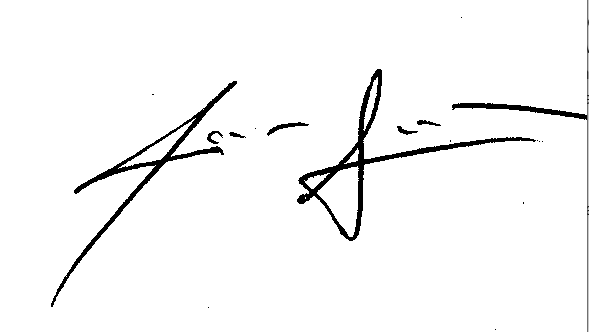

## Inversão da intensidade dos Pixels:

- De modo a facilitar a visualização e ressaltar as características da imagem, além da presença de ruídos, fez-se a inversão da intensidade dos pixels.

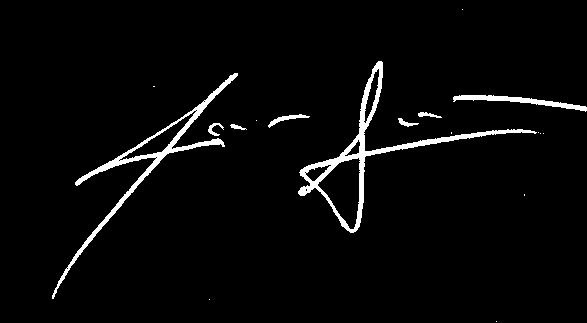

## Aplicação de Filtro Bilateral para retirada de ruído:

O filtro bilateral é aplicado a cada pixel da imagem, substituindo seu valor pela média ponderada dos valores dos pixels vizinhos, onde os pesos são determinados pela função de peso bilateral.

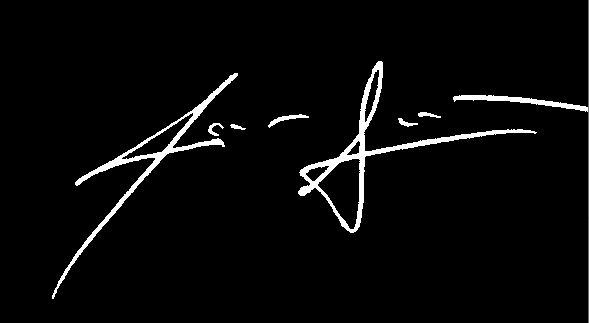

## Recorte da imagem, mantendo a imagem centralizada na tela:

- Ao recortar a imagem e remover o fundo que não contém a assinatura, forneceu-se ao modelo de verificação de assinaturas uma entrada mais relevante e significativa.


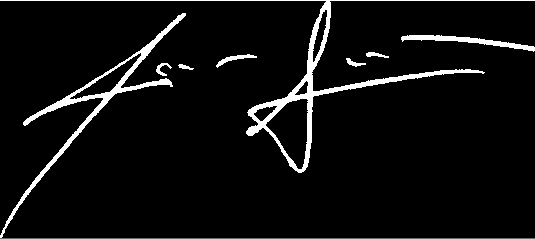

## Normalização do tamanho das imagens

- Aqui, fixou-se o tamanho de todas as imagens em um tamanho padrão. Isto é necessário para facilitar a extração das características pela rede neural e reduzir o custo computacional. Além disso, deixar a imagem quadrada (isto é, com mesma altura e comprimento), simplifica o pré-processamento dos dados, pois não precisa lidar com tamanhos variáveis de imagem durante o treinamento e a inferência.
Além disso, muitas implementações de redes convolucionais utilizam camadas de convolução e pooling que operam melhor em imagens com dimensões iguais. Manter a imagem quadrada pode ajudar a evitar distorções indesejadas durante o processamento.


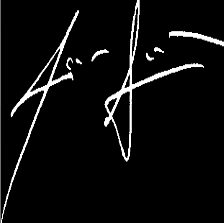

In [ ]:
def binarization(image):
  limiar, imagem_binaria = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return imagem_binaria

def recortar(imagem):
  vetor_linhas = []
  vetor_colunas = []
  linhas, colunas = imagem.shape
  for linha in range(linhas):
    if 255 in imagem[linha,:]:
      vetor_linhas.append(linha)
  for coluna in range(colunas):
    if 255 in imagem[:,coluna]:
      vetor_colunas.append(coluna)
  imagem_nova = imagem[min(vetor_linhas):max(vetor_linhas), min(vetor_colunas):max(vetor_colunas)]
  return imagem_nova

#-----------------------------------
def pre_process(imagem):
  imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
  #cv2.imshow('Imagem em escala de cinza', imagem_gray)
  #-----------------------------------
  binary_image = binarization(imagem_gray)
  #cv2.imshow('Imagem binarizada', binary_image)
  #-----------------------------------
  imagem_nova = cv2.bitwise_not(binary_image)
  #cv2.imshow('Imagem invertida', imagem_nova)
  #-----------------------------------
  diameter = 5 # Diâmetro da vizinhança para cálculo da média
  sigma_color = 250  # Valor sigma para a componente de cor
  sigma_space = 250  # Valor sigma para a componente espacial
  imagem_filtrada = binarization(cv2.bilateralFilter(imagem_nova, diameter, sigma_color, sigma_space))
  imagem_recortada = recortar(imagem_filtrada)
  imagem = imagem_recortada
  #cv2.imshow('Imagem Filtrada (Bilateral)', imagem_filtrada)
  #-----------------------------------
  imagem_final = color.gray2rgb(cv2.resize(imagem, (224,224)))
  imagem_final = preprocess_input(imagem_final)
  #cv2.imshow('Imagem Esqueleto', new_skeleton)
  #cv2.imshow('Imagem Final', new_skeleton)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()
  return imagem_final

# Carregamento das imagens a partir do Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
caminho_org = "/content/drive/My Drive/TG1/full_org"
caminho_forg = "/content/drive/My Drive/TG1/full_forg"
arquivos_org_png = []
arquivos_forg_png = []
for arquivo in os.listdir(caminho_org):
  if arquivo.endswith('.png'):
    caminho_completo = os.path.join(caminho_org, arquivo)
    imagem = cv2.imread(caminho_completo)
    if imagem is not None:
      arquivos_org_png.append(imagem)
for arquivo in os.listdir(caminho_forg):
  if arquivo.endswith('.png'):
    caminho_completo = os.path.join(caminho_forg, arquivo)
    imagem = cv2.imread(caminho_completo)
    if imagem is not None:
      arquivos_forg_png.append(imagem)

In [ ]:
arquivos_org_alterados = []
arquivos_forg_alterados = []
for imagem in arquivos_org_png:
  imagem_final = pre_process(imagem)
  arquivos_org_alterados.append(imagem_final)

for imagem in arquivos_forg_png:
  imagem_final = pre_process(imagem)
  arquivos_forg_alterados.append(imagem_final)

# Extração de Features usando a Vgg19

A escolha da Vgg19 para a tarefa de feature extraction se deu devido a alguns fatores:

- A VGG19 é uma rede relativamente profunda, composta por 19 camadas (daí o nome). A profundidade da rede pode permitir que ela capture características mais complexas e abstratas em comparação com redes mais rasas. Isso é particularmente útil em tarefas de visão computacional, onde a hierarquia de características é fundamental para o reconhecimento de objetos.

- A VGG19 utiliza principalmente filtros de convolução com um pequeno tamanho de janela (3x3 pixels) em todas as camadas convolucionais. Esses filtros menores têm a vantagem de aprender características locais mais detalhadas e podem capturar padrões finos na imagem.

- A VGG19 foi treinada em conjuntos de dados massivos, como o ImageNet, para tarefas de classificação de imagem. Como resultado, as características aprendidas pela VGG19 podem ser úteis em uma variedade de tarefas de visão computacional, mesmo que o conjunto de dados de destino seja diferente do conjunto em que a VGG19 foi treinada. Isso torna a VGG19 uma escolha popular para tarefas de transferência de aprendizado, onde se deseja aproveitar o conhecimento prévio da rede para tarefas específicas.

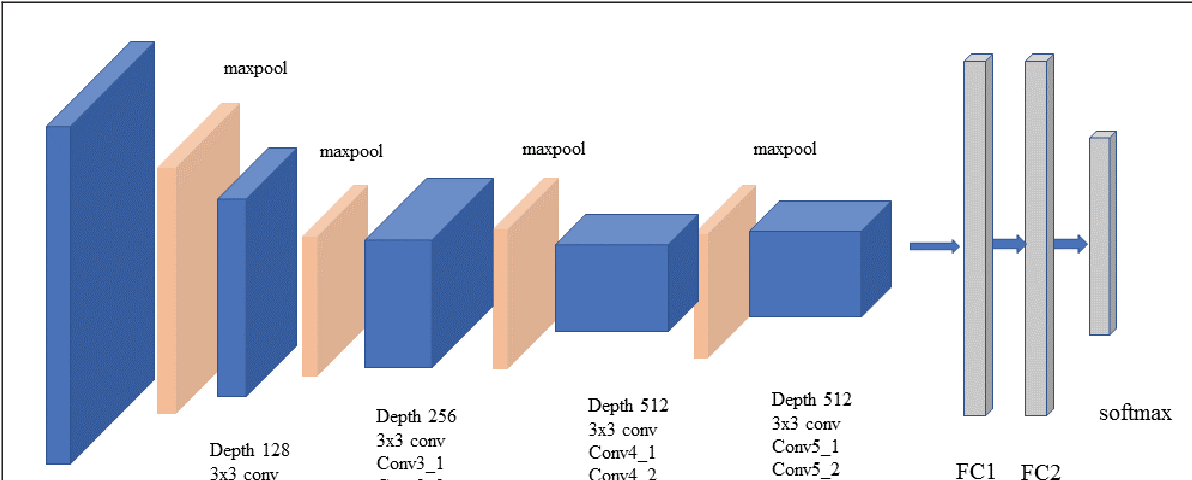

In [ ]:
features_org = []
features_forg = []

model = VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))

def extract_features(image):
  imagem = image.astype('float32') / 127.0
  img = np.expand_dims(imagem, axis=0)
  features = model.predict(img)
  return features.flatten()

for image in arquivos_org_alterados:
  feature = extract_features(image)
  features_org.append(feature)

for image in arquivos_forg_alterados:
  feature = extract_features(image)
  features_forg.append(feature)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1

# Treinamento do Classificador

In [ ]:
features = features_org + features_forg
num_instancias_classe_1 = len(arquivos_org_png)
num_instancias_classe_0 = len(arquivos_forg_png)
labels_classe_1 = np.ones(num_instancias_classe_1)
labels_classe_0 = np.zeros(num_instancias_classe_0)
labels = np.concatenate((labels_classe_1, labels_classe_0))


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify = labels)

print("Distribuição dos rótulos no conjunto de treinamento:")
print("Classe 1:", sum(y_train == 1))
print("Classe 0:", sum(y_train == 0))

print("\nDistribuição dos rótulos no conjunto de teste:")
print("Classe 1:", sum(y_test == 1))
print("Classe 0:", sum(y_test == 0))

print(max(X_train[0]))
print(max(X_train[1]))
print(min(X_train[0]))
print(min(X_train[1]))

Distribuição dos rótulos no conjunto de treinamento:
Classe 1: 923
Classe 0: 924

Distribuição dos rótulos no conjunto de teste:
Classe 1: 396
Classe 0: 396
9.799601
9.855167
0.0
0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [ ]:
svm_model = SVC(probability=True, kernel='rbf', C = 100)
svm_model.fit(X_train_normalized, y_train)
# Prever os rótulos para o conjunto de teste
y_pred = svm_model.predict(X_test_normalized)
# Calcular a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.9671717171717171

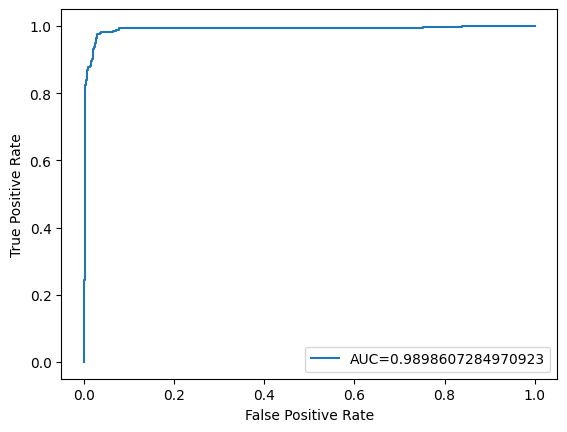

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
y_pred_proba_svm = svm_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_svm)
auc = metrics.roc_auc_score(y_test, y_pred_proba_svm)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_svm)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer_svm = fpr[np.nanargmin(np.abs(fpr - fnr))]
print(f"EER: {eer_svm:.7f} (com threshold = {eer_threshold:.4f})")

EER: 0.0303030 (com threshold = 1.0000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lr_model = LogisticRegression(max_iter=1000, random_state=41, C= 100, penalty =  'l2', solver=  'liblinear')
lr_model.fit(X_train_normalized, y_train)
y_pred_lr = lr_model.predict(X_test_normalized)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr}')
print(f'Confusion Matrix:\n {cm_lr}')
print(f'Classification Report:\n {report_lr}')


Logistic Regression Accuracy: 0.9621212121212122
Confusion Matrix:
 [[378  18]
 [ 12 384]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       396
         1.0       0.96      0.97      0.96       396

    accuracy                           0.96       792
   macro avg       0.96      0.96      0.96       792
weighted avg       0.96      0.96      0.96       792



In [ ]:
y_pred_proba_lr = lr_model.predict_proba(X_test_normalized)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer_lr = fpr[np.nanargmin(np.abs(fpr - fnr))]

print(f"EER: {eer_lr:.7f} (com threshold = {eer_threshold:.4f})")

EER: 0.0378788 (com threshold = 0.6146)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 4, weights = 'uniform')
knn_model.fit(X_train_normalized, y_train)
y_pred_knn = knn_model.predict(X_test_normalized)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn}')
print(f'Confusion Matrix:\n {cm_knn}')
print(f'Classification Report:\n {report_knn}')

KNN Accuracy: 0.9482323232323232
Confusion Matrix:
 [[379  17]
 [ 24 372]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       396
         1.0       0.96      0.94      0.95       396

    accuracy                           0.95       792
   macro avg       0.95      0.95      0.95       792
weighted avg       0.95      0.95      0.95       792



In [ ]:
y_pred_proba_knn = knn_model.predict_proba(X_test_normalized)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer_knn = fpr[np.nanargmin(np.abs(fpr - fnr))]

print(f"EER: {eer_knn:.7f} (com threshold = {eer_threshold:.4f})")

EER: 0.0429293 (com threshold = 0.7500)


In [ ]:
# Instanciando o modelo
rf_model = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_model.fit(X_train_normalized, y_train)
y_pred_rf = rf_model.predict(X_test_normalized)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')
print(f'Confusion Matrix:\n {cm_rf}')
print(f'Classification Report:\n {report_rf}')

In [ ]:
y_pred_proba_rf = rf_model.predict_proba(X_test_normalized)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer_rf = fpr[np.nanargmin(np.abs(fpr - fnr))]

print(f"EER: {eer_rf:.7f} (com threshold = {eer_threshold:.4f})")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados de exemplo - substitua pelos valores reais das acurácias e EERs
classifiers = ['SVM', 'Random Forest', 'Logistic Regression', 'KNN']
accuracies = [accuracy, accuracy_rf, accuracy_lr, accuracy_knn]  # Exemplo de acurácias
eers = [eer_svm, eer_rf, eer_lr, eer_knn]  # Exemplo de EERs (Equal Error Rate)

# Gráfico de barras para as acurácias
# Cores para cada classificador
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Gráfico de barras para as acurácias
plt.figure(figsize=(10, 5))
bars1 = plt.bar(classifiers, accuracies, color=colors)
plt.ylim(0, 1.5)  # Limitando de 0 a 1 para escala de acurácia
plt.title('Acurácia dos Classificadores')
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')

# Adicionando os valores nas barras
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

plt.show()

# Gráfico de barras para as EERs
plt.figure(figsize=(10, 5))
bars2 = plt.bar(classifiers, eers, color=colors)
plt.ylim(0, 0.5)  # Limitando de 0 a 1 para escala de EER
plt.title('Equal Error Rate (EER) dos Classificadores')
plt.xlabel('Classificadores')
plt.ylabel('EER')

# Adicionando os valores nas barras
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

plt.show()
